<a href="https://colab.research.google.com/github/pvpogorelova/metrics_25_26/blob/main/RDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Разрывный регрессионный дизайн.**

# **Sharp RDD: пример с партией власти.**

В своем анализе авторы фокусируются на исследовании выборов в законодательные собрания штатов США, проведенном Фурнаисом и Холлом. Эмпирическая база включает 32 670 избирательных гонок на уровне округов по выборам в органы власти штатов.

## **Постановка задачи.**

* **Основной исследовательский вопрос:** Влияет ли победа на выборах в год (t) на финансовую поддержку этой партии в следующем цикле (t+1).

* **Проблема:** Мы не можем просто сравнить округа, где партия победила, с округами, где она проиграла. Эти округа могут систематически отличаться (например, быть более консервативными или урбанизированными), и простой подсчет разницы в результатах будет смещенным.

* **Решение (метод RDD):** Мы используем жесткое административное правило: побеждает кандидат, набравший более 50% голосов. Это создает четкий порог (cutoff). Метод RDD позволяет сравнить округа, где партия победила с очень небольшим перевесом (например, 50.1%), с округами, где она проиграла с очень небольшим отставанием (49.9%). Считается, что такие округа практически идентичны по всем наблюдаемым и ненаблюдаемым характеристикам, а разница в победе является почти случайной. Поэтому любое последующее различие в результатах на выборах t+1 можно интерпретировать как причинный эффект самого статуса победителя (incumbency).

* **Гипотеза:** Мы ожидаем, что эффект incumbency advantage будет положительным и статистически значимым (оценки из литературы: +5–10 процентных пунктов).


## **Описание данных.**

**x_score_victorymargin**	– (running variable): перевес демократов на выборах в момент времени t.
Рассчитывается как: (Процент голосов, полученных Демократической партией) минус (Процент голосов, полученных ее сильнейшим оппонентом).	Ключевая непрерывная переменная, определяющая, получила ли партия "воздействие" (победу). Позволяет применить RDD с порогом 0.

**y_donationshare**	– основная переменная результата (outcome variable): доля донатов, направленных партии, обладающей статусом действующего лица (incumbent's party), в процентах.	Главный зависимый показатель. Исследование оценивает, как победа на выборах (t) влияет на финансовую поддержку этой партии в следующем цикле (t+1).

**cov_total_race_money** – контрольная переменная: общий объем денежных средств в избирательной гонке.

**cov_total_votes**	– контрольная переменная: общее количество голосов в округе.

**cov_dem_inc**	– контрольная переменная: =1, если республикант является действующим лицом (на момент выборов t?) (учитывает, обладала ли Демократическая партия статусом действующей до рассматриваемых выборов).

**cov_rep_inc**	– контрольная переменная: =1, если демократ является действующим лицом (на момент выборов t?) (учитывает, обладала ли Республиканская партия статусом действующей до рассматриваемых выборов).

**cov_total_group_money**	– контрольная переменная: общий объем средств от групп (вероятно, политических комитетов, PACs), отражающая специфический источник финансирования в избирательной кампании.

In [33]:
pip install rdrobust

In [45]:
import pandas as pd
import numpy as np
from rdrobust import rdplot, rdbwselect, rdrobust
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [48]:
data_rdd = pd.read_stata("https://docs.google.com/uc?id=1xWHmST5FYcfLxe9V7Hwqd2LIy_A3ninG&export=download")

# Переименование столбцов
data_rdd.rename(columns={'rv': 'x_score_victorymargin',
                         'dv_money': 'y_donationshare',
                         'statelevel': 'cov_statelevel',
                         'total_race_money': 'cov_total_race_money',
                         'total_votes': 'cov_total_votes',
                         'dem_inc': 'cov_dem_inc',
                         'rep_inc': 'cov_rep_inc',
                         'total_group_money': 'cov_total_group_money'},
                inplace=True)

# Выбор необходимых столбцов
columns_to_keep = ['x_score_victorymargin',
                   'y_donationshare',
                   'cov_statelevel',
                   'cov_total_race_money',
                   'cov_total_votes',
                   'cov_dem_inc',
                   'cov_rep_inc',
                   'cov_total_group_money',
                   'state',
                   'dist',
                   'year']

data_rdd = data_rdd[columns_to_keep]

In [49]:
data_rdd

,x_score_victorymargin,y_donationshare,cov_statelevel,cov_total_race_money,cov_total_votes,cov_dem_inc,cov_rep_inc,cov_total_group_money,state,dist,year
0,-5.498560,6.119337,0.0,NaN,NaN,NaN,NaN,NaN,AK,90.0,1978.0
1,-24.078474,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,AK,90.0,1980.0
2,-21.150679,39.586037,0.0,NaN,NaN,NaN,NaN,NaN,AK,90.0,1982.0
3,-6.677437,30.142197,0.0,NaN,NaN,NaN,NaN,NaN,AK,90.0,1984.0
4,-7.705765,34.415070,0.0,NaN,NaN,NaN,NaN,NaN,AK,90.0,1986.0
...,...,...,...,...,...,...,...,...,...,...,...
39198,50.000000,100.000000,1.0,1265.199951,2248.0,1.0,0.0,1125.0,WY,60.0,2002.0
39199,50.000000,100.000000,1.0,1425.000000,2952.0,1.0,0.0,1425.0,WY,60.0,2004.0
39200,50.000000,100.000000,1.0,1875.000000,2395.0,1.0,0.0,1875.0,WY,60.0,2006.0
39201,50.000000,76.950470,1.0,3125.000000,2891.0,1.0,0.0,2700.0,WY,60.0,2008.0


In [47]:
fig = go.Figure()

# Разделяем данные на две группы
treatment = data_rdd[data_rdd['x_score_victorymargin'] >= 0]
control = data_rdd[data_rdd['x_score_victorymargin'] < 0]

fig.add_trace(go.Scatter(
    x=control['x_score_victorymargin'],
    y=control['y_donationshare'],
    mode='markers',
    name='Control Group',
    marker=dict(size=3, opacity=0.4, color='blue')
))

fig.add_trace(go.Scatter(
    x=treatment['x_score_victorymargin'],
    y=treatment['y_donationshare'],
    mode='markers',
    name='Treatment Group',
    marker=dict(size=3, opacity=0.4, color='red')
))

# Добавляем вертикальную линию на пороге
fig.add_vline(x=0, line_width=1, line_dash="dash", line_color="green")

fig.update_layout(
    title="Margin of Victory and Donation Share",
    xaxis_title='Democratic margin of victory at t',
    yaxis_title='Democratic share of contributions at t+1'
)

fig.show()

Проанализируем, влияет ли статус действующей власти на общий объем денежных средств в избирательной гонке

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
                       Coeff
Conventional    -7945.130096
Bias-Corrected -14849.560942
Robust         -14849.560942
Mass points detected in the running variable.


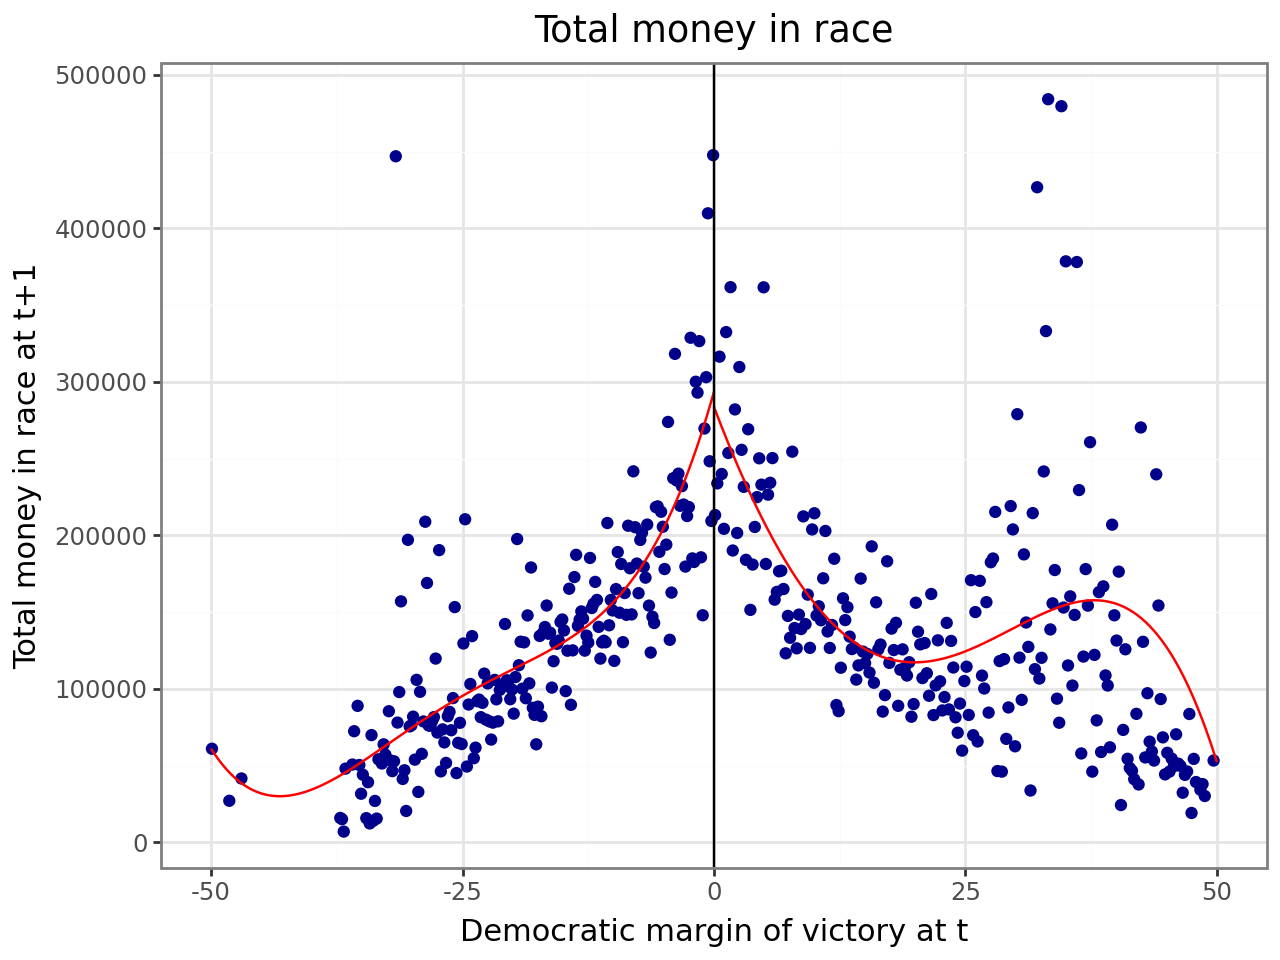

Call: rdplot
Number of Observations:                 32670
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations         16281      16389
Number of Effective Obs        16281      16389
Bandwith poly. fit (h)          50.0       50.0
Number of bins scale               1          1
Bins Selected                    290        228
Average Bin Length             0.185      0.219
Median Bin Length              0.172      0.219
IMSE-optimal bins               21.0       23.0
Mimicking Variance bins        290.0      228.0

Relative to IMSE-optimal:
Implied scale                  13.81      9.913
WIMSE variance weight            0.0      0.001
WIMSE bias weight                1.0      0.999


In [50]:
# Total money in race
cov_total_race_money = data_rdd['cov_total_race_money'].values
x_score_victorymargin = data_rdd['x_score_victorymargin'].values

# Подбор ширины окна
bandwidth = rdbwselect(cov_total_race_money, x_score_victorymargin)

# Анализ разрывной регрессии
results = rdrobust(y=cov_total_race_money, x=x_score_victorymargin, c=0)

# Выводим сводную статистику
print(results.coef)

# Построение графика
rdplot(y=cov_total_race_money, x=x_score_victorymargin,  title='Total money in race',
       x_label='Democratic margin of victory at t', y_label='Total money in race at t+1')

Теперь посмотрим, влияет ли статус действующей власти на общий число голосов на следующих выборах

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
                      Coeff
Conventional   -1629.163952
Bias-Corrected -2160.742077
Robust         -2160.742077
Mass points detected in the running variable.


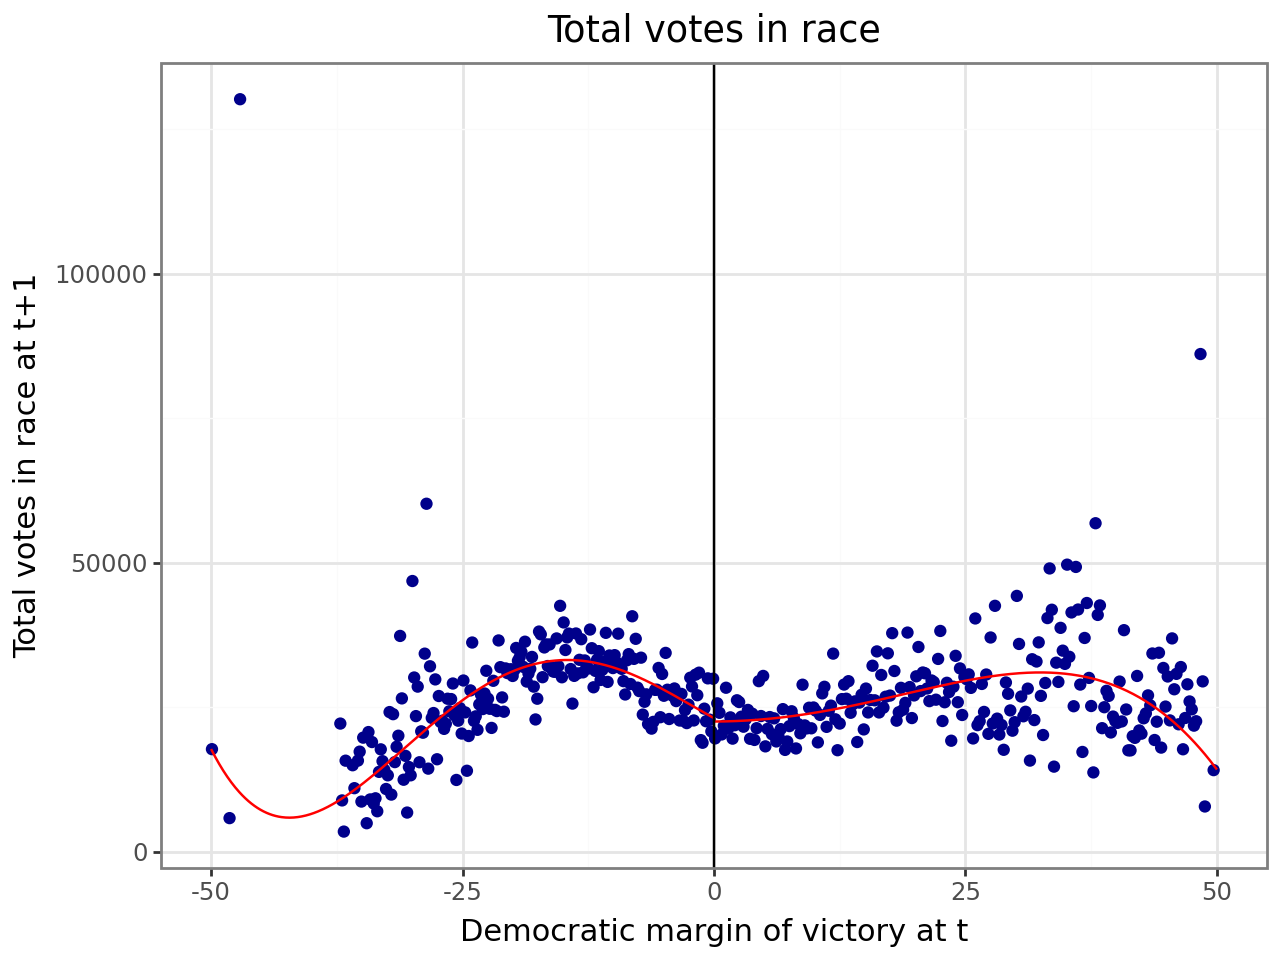

Call: rdplot
Number of Observations:                 32670
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations         16281      16389
Number of Effective Obs        16281      16389
Bandwith poly. fit (h)          50.0       50.0
Number of bins scale               1          1
Bins Selected                    286        230
Average Bin Length             0.186      0.217
Median Bin Length              0.175      0.217
IMSE-optimal bins               31.0       24.0
Mimicking Variance bins        286.0      230.0

Relative to IMSE-optimal:
Implied scale                  9.226      9.583
WIMSE variance weight          0.001      0.001
WIMSE bias weight              0.999      0.999


In [51]:
# Total votes in race
cov_total_votes = data_rdd['cov_total_votes'].values

# Подбор ширины окна
bandwidth = rdbwselect(cov_total_votes, x_score_victorymargin)

# Анализ разрывной регрессии
results = rdrobust(y=cov_total_votes, x=x_score_victorymargin, c=0)

# Выводим сводную статистику
print(results.coef)

# Построение графика
rdplot(y=cov_total_votes, x=x_score_victorymargin, title='Total votes in race',
       x_label='Democratic margin of victory at t', y_label='Total votes in race at t+1')

И в заключении проанализируем, влияет ли статус действующей власти на долю донатов на следующих выборах

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
                    Coeff
Conventional    21.107942
Bias-Corrected  20.593546
Robust          20.593546
Mass points detected in the running variable.


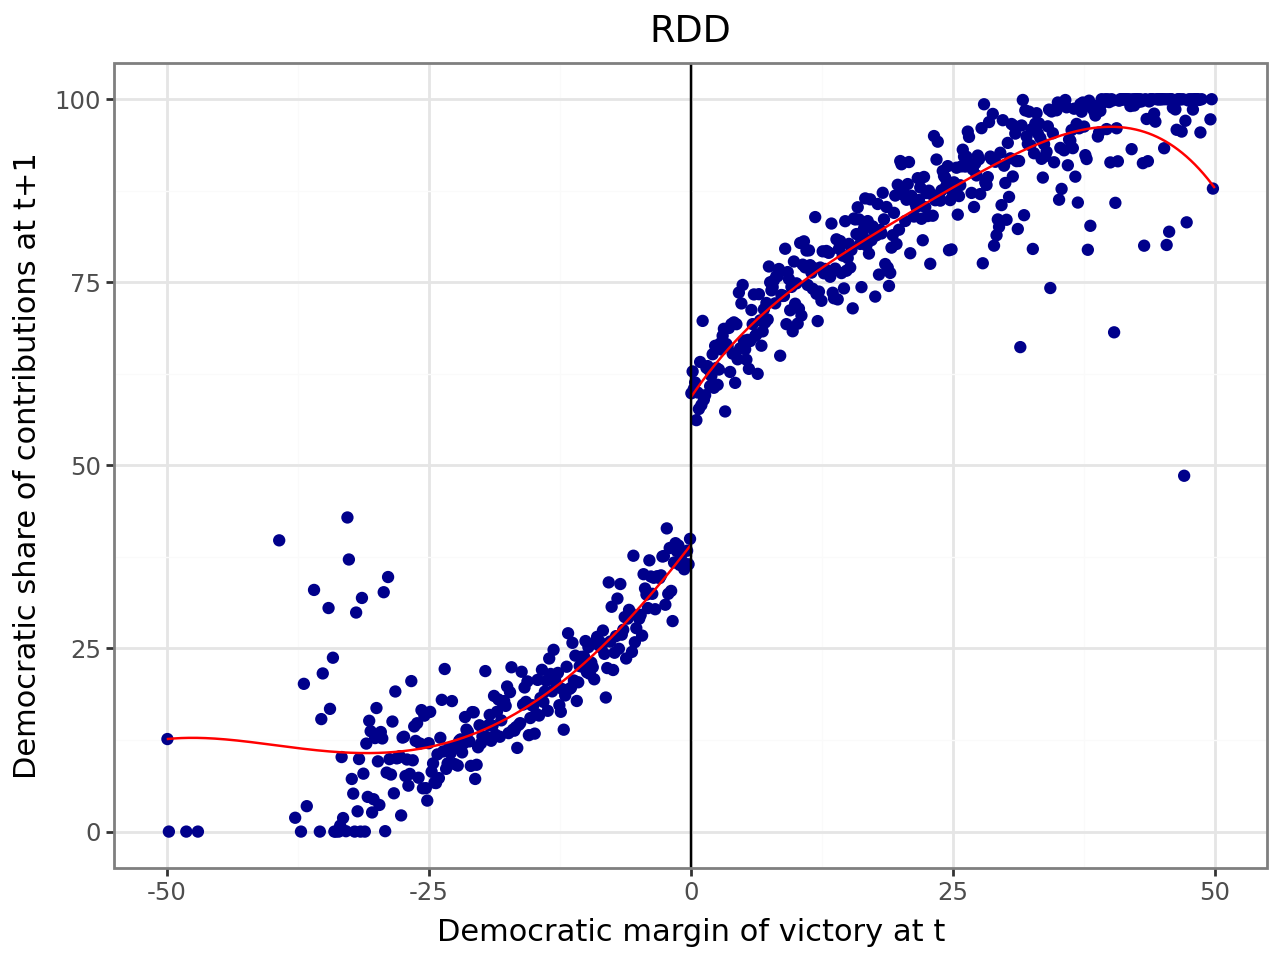

Call: rdplot
Number of Observations:                 31529
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations         15286      16243
Number of Effective Obs        15286      16243
Bandwith poly. fit (h)          50.0       50.0
Number of bins scale               1          1
Bins Selected                    361        419
Average Bin Length             0.133      0.119
Median Bin Length              0.139      0.119
IMSE-optimal bins               25.0       32.0
Mimicking Variance bins        361.0      419.0

Relative to IMSE-optimal:
Implied scale                  14.44     13.094
WIMSE variance weight            0.0        0.0
WIMSE bias weight                1.0        1.0


In [52]:
# Локальная полиномиальная регрессия в RDD
y_donationshare = data_rdd['y_donationshare'].values

# Подбор ширины окна
bandwidth = rdbwselect(y_donationshare, x_score_victorymargin)

# Анализ разрывной регрессии
rdd_results = rdrobust(y=y_donationshare, x=x_score_victorymargin, c=0)

# Выводим сводную статистику
print(rdd_results.coef)

# Изобразим результаты RDD на графике
rdplot(y=y_donationshare, x=x_score_victorymargin, c=0,
       x_label='Democratic margin of victory at t',
       y_label='Democratic share of contributions at t+1',
       title='RDD')

In [12]:
# Плацебо тест: попробуем изменить значение переменной отбора (cutoff)
# c = 1
y_donationshare = data_rdd['y_donationshare'].values
x_score_victorymargin = data_rdd['x_score_victorymargin'].values

# Анализ разрывной регрессии с c = 1
rdd_c1 = rdrobust(y=y_donationshare, x=x_score_victorymargin, c=1, all=True)
print(f"\nCutoff c = 1:\n{rdd_c1.pv}")

# cutoff (значение переменной отбора) c = -3
# Анализ разрывной регрессии с c = -3
rdd_c3 = rdrobust(y=y_donationshare, x=x_score_victorymargin, c=-3, all=True)
print(f"\nCutoff c = -3:\n{rdd_c3.pv}")

Mass points detected in the running variable.
Mass points detected in the running variable.

Cutoff c = 1:
                   P>|t|
Conventional    0.289638
Bias-Corrected  0.123701
Robust          0.144081
Mass points detected in the running variable.
Mass points detected in the running variable.

Cutoff c = -3:
                   P>|t|
Conventional    0.087510
Bias-Corrected  0.033444
Robust          0.056713


## **Fuzzy RDD**

**Описание эксперимента**: Студенты сдают вступительный экзамен в начале учебного года.
Если они набирают 70 баллов или ниже, их зачисляют на бесплатную программу репетиторства.
В конце года студенты сдают выпускной экзамен.

Возможно, что некоторые люди набрали больше баллов на вступительном экзамене и каким-то образом воспользовались услугами репетитора, или что некоторые люди набрали меньше баллов, но не приняли участие в программе.

**Исследовательский вопрос:** эффективна ли данная программа репетиторства?

In [15]:
tutoring_program = pd.read_csv("/content/tutoring_program_fuzzy.csv")

## **Описание переменных.**

* **entrance_exam** – балл за вступительный экзамен в начале года
* **tutoring** – переменная воздействия, =1, если студент посещал дополнительные занятия
* **exit_exam** – балл за экзамен в конце года

In [16]:
tutoring_program

,id,entrance_exam,tutoring,tutoring_text,exit_exam
0,1,92.408325,False,No tutor,78.075917
1,2,72.772380,False,No tutor,58.217569
2,3,53.650898,True,Tutor,61.965432
3,4,98.326883,False,No tutor,67.489561
4,5,69.712194,True,Tutor,54.128883
...,...,...,...,...,...
995,996,43.704837,True,Tutor,65.342376
996,997,39.221416,True,Tutor,53.595402
997,998,90.287910,False,No tutor,76.671979
998,999,62.199722,False,No tutor,59.306961


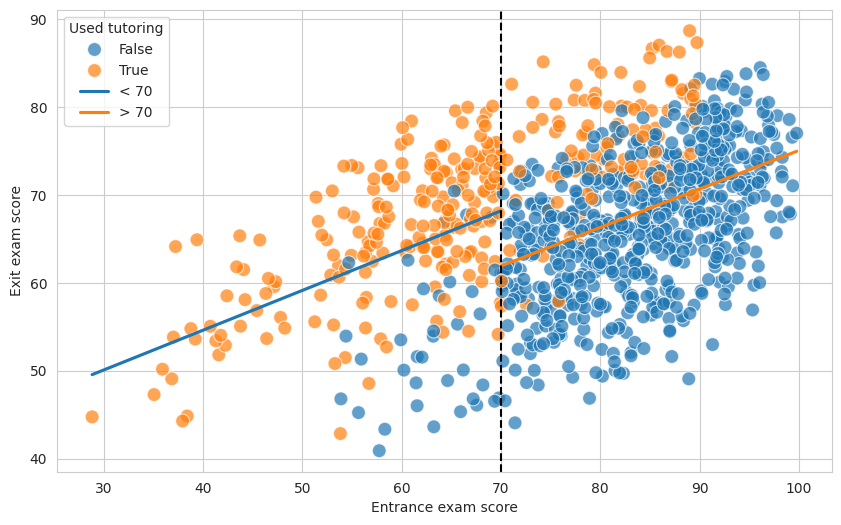

In [54]:
# Построим график
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x="entrance_exam",
    y="exit_exam",
    hue="tutoring",
    data=tutoring_program,
    s=100,
    alpha=0.7
)

# Добавим линию регрессии для тех, кто набрал меньше 70 баллов
low_data = tutoring_program.query('entrance_exam <= 70')
sns.regplot(
    x="entrance_exam",
    y="exit_exam",
    data=low_data,
    scatter=False,
    ci=None,
    truncate=True,
    label='< 70'
)

# Добавим на график линию регрессии для тех, кто набрал больше 70 баллов
high_data = tutoring_program.query('entrance_exam > 70')
sns.regplot(
    x="entrance_exam",
    y="exit_exam",
    data=high_data,
    scatter=False,
    ci=None,
    truncate=True,
    label='> 70'
)

# Вертикальная линия на отметке 70 баллов
plt.axvline(70, color='black', linestyle='--')


plt.xlabel('Entrance exam score')
plt.ylabel('Exit exam score')
plt.legend(title = 'Used tutoring')

plt.show()

/tmp/ipython-input-2869355637.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



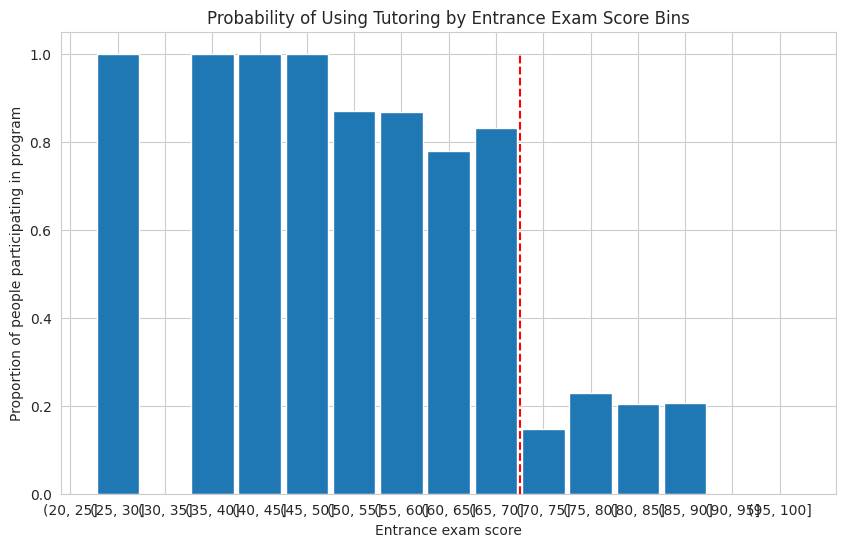

In [18]:
# Разбиение столбца entrance_exam на категории
bins = list(range(0, 101, 5))
labels = [f'({i}, {j}]' for i, j in zip(bins[:-1], bins[1:])]
tutoring_program['exam_binned'] = pd.cut(tutoring_program['entrance_exam'], bins=bins, labels=labels, right=False)

# Группировка по категориям и дамми на занятия у репетитора
grouped = tutoring_program.groupby(['exam_binned', 'tutoring']).size().reset_index(name='count')

pivoted = grouped.pivot(index='exam_binned', columns='tutoring', values='count').fillna(0).reset_index()
pivoted.columns.name = None
pivoted.rename(columns={True: 'tutor_yes', False: 'tutor_no'}, inplace=True)

# Вычисление вероятности занятий у репетитора
pivoted['prob_tutoring'] = pivoted['tutor_yes'] / (pivoted['tutor_yes'] + pivoted['tutor_no'])

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(pivoted['exam_binned'], pivoted['prob_tutoring'], width=0.9)
plt.vlines(13.5, ymin=0, ymax=1, colors='r', linestyles='dashed')
plt.xlabel('Entrance exam score')
plt.ylabel('Proportion of people participating in program')
plt.title('Probability of Using Tutoring by Entrance Exam Score Bins')
plt.grid(True)
plt.show()

In [19]:
tutoring_program['entrance_centered'] = tutoring_program["entrance_exam"] - 70
tutoring_program

,id,entrance_exam,tutoring,tutoring_text,exit_exam,exam_binned,entrance_centered
0,1,92.408325,False,No tutor,78.075917,"(90, 95]",22.408325
1,2,72.772380,False,No tutor,58.217569,"(70, 75]",2.772380
2,3,53.650898,True,Tutor,61.965432,"(50, 55]",-16.349102
3,4,98.326883,False,No tutor,67.489561,"(95, 100]",28.326883
4,5,69.712194,True,Tutor,54.128883,"(65, 70]",-0.287806
...,...,...,...,...,...,...,...
995,996,43.704837,True,Tutor,65.342376,"(40, 45]",-26.295163
996,997,39.221416,True,Tutor,53.595402,"(35, 40]",-30.778584
997,998,90.287910,False,No tutor,76.671979,"(90, 95]",20.287910
998,999,62.199722,False,No tutor,59.306961,"(60, 65]",-7.800278


In [31]:
# Выведем оценки эффектов воздействия
mod_rdd = rdrobust(y=tutoring_program['exit_exam'], x=tutoring_program['entrance_centered'], fuzzy=tutoring_program['tutoring'])
print(mod_rdd.coef)

                   Coeff
Conventional    9.683140
Bias-Corrected  9.652212
Robust          9.652212


In [32]:
# И выведем доверительные интервалы
print(mod_rdd.ci)

                CI Lower   CI Upper
Conventional    5.973275  13.393005
Bias-Corrected  5.942347  13.362077
Robust          5.209567  14.094857
